In [57]:

import time

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from functools import reduce
import itertools

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest
from darts.utils.statistics import SeasonalityMode
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta, 
    RegressionEnsembleModel,
    FourTheta,
    NBEATSModel,
    NHiTSModel,
    RandomForest,
    LightGBMModel)               # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.utils.utils import ModelMode           # new 
from darts.utils.missing_values import fill_missing_values

from darts.datasets import ( 
    AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset, HeartRateDataset, 
    IceCreamHeaterDataset, MonthlyMilkDataset, SunspotsDataset)


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)



TRACE = False                 # print also the suboptimal models while SARIMA tuning process is running
MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

In [58]:
# Connect to snowflake
from snowflake.snowpark import Session
import json
credentials = json.load(open('secrets.json'))["SNOWFLAKE_CONNECTION"]

session = Session.builder.configs(credentials).create()

In [59]:
session.use_database("HACKATHON")
session.use_schema("public")
mdf = session.table("CHALLENGE1_TRAIN_DATA")

In [60]:
df = mdf.to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284700 entries, 0 to 284699
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DATE          284700 non-null  object 
 1   DC_NAME       284700 non-null  object 
 2   SIZE_CODE     284700 non-null  int32  
 3   RETAIL_PRICE  284666 non-null  float64
 4   TOTAL_TIRES   284700 non-null  int16  
 5   ZIP_CODE      284700 non-null  int32  
dtypes: float64(1), int16(1), int32(2), object(2)
memory usage: 9.2+ MB


# Prepare the data

In [61]:
gb = df.groupby(['DC_NAME','SIZE_CODE'])
frames = {}    
frames = [gb.get_group(x) for x in gb.groups]
len(frames)
display(frames[3])

,DATE,DC_NAME,SIZE_CODE,RETAIL_PRICE,TOTAL_TIRES,ZIP_CODE
175503,2022-05-23,BAKERSFIELD,1956015,91.045,1,93308
175504,2021-01-26,BAKERSFIELD,1956015,44.545,3,93308
175505,2022-06-21,BAKERSFIELD,1956015,90.055,6,93308
175506,2022-02-22,BAKERSFIELD,1956015,71.665,9,93308
175507,2022-02-10,BAKERSFIELD,1956015,79.910,9,93308
...,...,...,...,...,...,...
271574,2021-03-07,BAKERSFIELD,1956015,0.000,0,93308
271575,2020-09-20,BAKERSFIELD,1956015,0.000,0,93308
271576,2021-03-14,BAKERSFIELD,1956015,0.000,0,93308
271577,2022-02-27,BAKERSFIELD,1956015,0.000,0,93308


In [62]:
ts_list = []
series_list = []
for frame in frames:
    frame = frame[['DATE', 'TOTAL_TIRES']]
    frame['DATE'] = pd.to_datetime(frame['DATE'])
    frame.set_index(keys='DATE', inplace=True, drop=True)
    frame = frame.sort_index()
    series_list.append(frame)
    ts = TimeSeries.from_series(frame, fill_missing_dates=True)
    ts_list.append(ts)

,DATE,DC_NAME,SIZE_CODE,RETAIL_PRICE,TOTAL_TIRES,ZIP_CODE
8763,2022-01-14,OAKLAND,2155516,85.91,1,94604
8764,2020-10-06,OAKLAND,2155516,93.91,1,94604
8765,2020-10-08,OAKLAND,2155516,59.91,1,94604
8766,2021-05-11,OAKLAND,2155516,48.09,2,94604
8767,2021-12-22,OAKLAND,2155516,105.31,2,94604
...,...,...,...,...,...,...
239027,2021-02-21,OAKLAND,2155516,0.00,0,94604
239028,2021-06-13,OAKLAND,2155516,0.00,0,94604
239029,2022-01-02,OAKLAND,2155516,0.00,0,94604
239030,2022-05-22,OAKLAND,2155516,0.00,0,94604


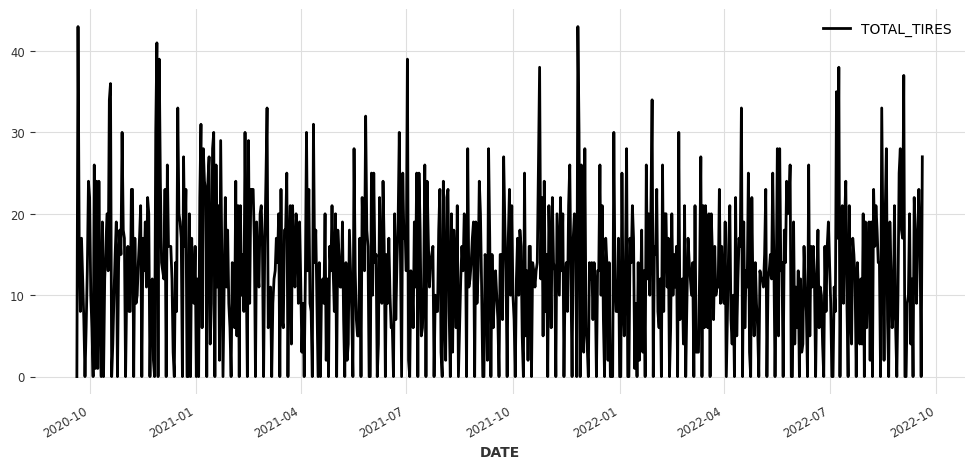

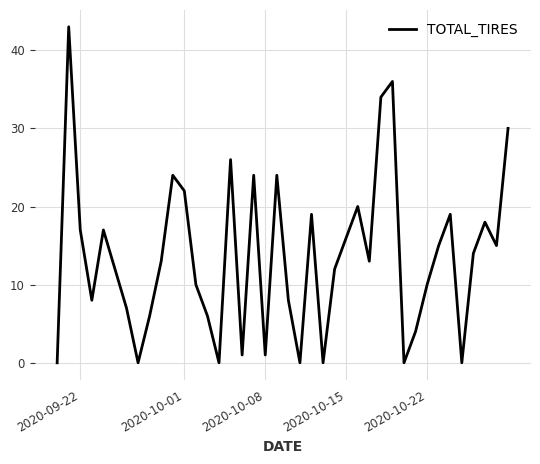

In [63]:
display(frames[120])
# display(ts[0])
# plot the observations

plt.figure(100, figsize=(12, 5))
ts_list[120].plot()
plt.show()
ts_list[120][0:40].plot()
plt.show()

# Check for Outliers considering seasonality and trend

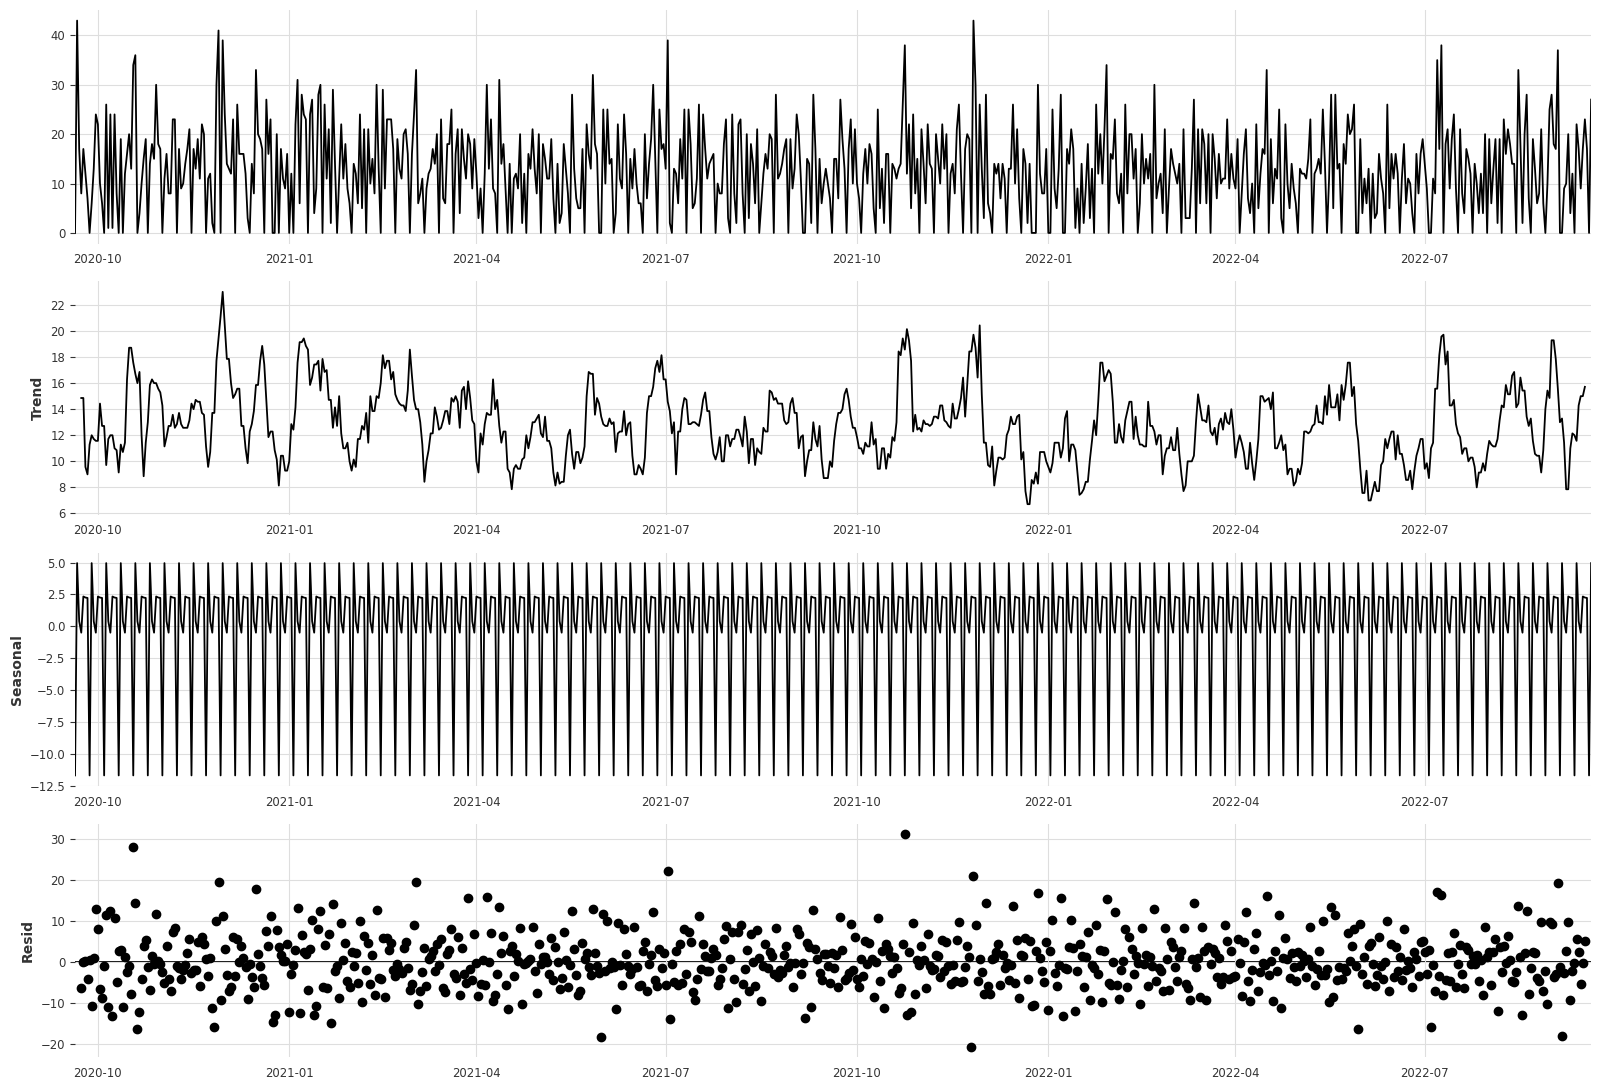

In [8]:
# Check for outliers despite seasonality and trend
#compute seasonal decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(series_list[120], period=7)

#plot decomp
fig = decomp.plot()
fig.set_size_inches((16, 11))
fig.tight_layout()
plt.show()

# Check for seasonality

In [64]:
mseas_list = []
check_list = [0,15,120,220]
for ts_example in check_list:
    for m in [7,30,31,365]:
        is_seasonal, mseas = check_seasonality(ts_list[ts_example], m=m, alpha=ALPHA, max_lag=m+1)
        if is_seasonal:
            mseas_list.append(mseas)
        else:
            continue
    if mseas_list != []:
        is_seasonal = True
    else:
        is_seasonal = False

print(f'list of seasonalities = {mseas_list}')

# Set it for weekly, since there is a higher confidence of weekly seasonality
mseas = 7

list of seasonalities = [7, 31, 7, 31, 7, 31, 7]


584 training obs
146 testing obs


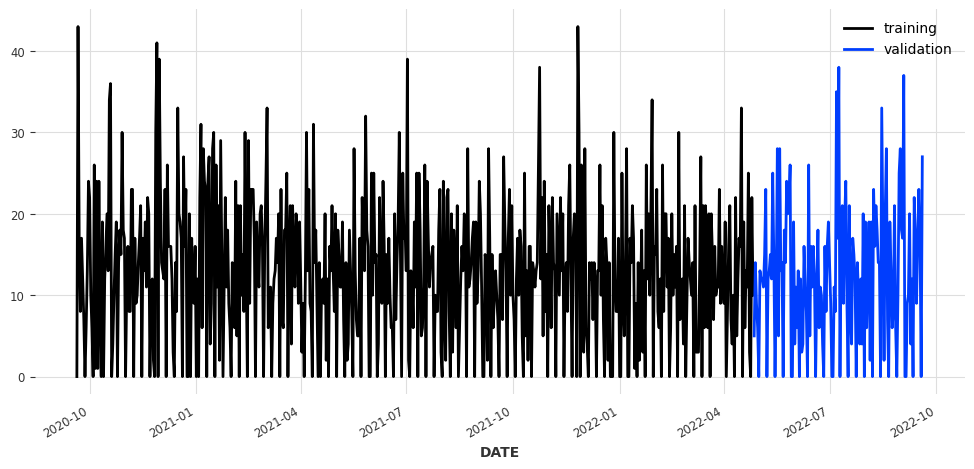

In [65]:
## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split

# if isinstance(TRAIN, numbers.Number):
#     split_at = TRAIN
# else:
#     split_at = pd.Timestamp(TRAIN)
# train, val = ts.split_before(split_at)

from darts.utils import model_selection
train_list = []
val_list = []

for ts in ts_list:
    train, val = model_selection.train_test_split(ts, test_size=0.20, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)
    
    train_list.append(train)
    val_list.append(val)

plt.figure(101, figsize=(12, 5))
train_list[120].plot(label='training')
val_list[120].plot(label='validation')
plt.legend();
print(f'{len(train)} training obs')
print(f'{len(val)} testing obs')

# Functions for pipeline. Building Models and Results

In [66]:
# compute accuracy metrics and processing time

def accuracy_metrics(act, forecast, resid, t_start):
    sr = resid.pd_series()
    sa = act.pd_series()
    n_act = len(act)
    # res_mape = mape(act, forecast)
    res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    res_pe = sr / sa
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error

    res_time = time.perf_counter() - t_start
    
    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    # res_accuracy = {"MAPE":res_mape,"RMSE":res_rmse, "-R squared":-res_r2, 
    #     "se": res_sefc, "time":res_time}
    res_accuracy = {"RMSE":res_rmse, "-R squared":-res_r2, 
        "se": res_sefc, "time":res_time}
    return res_accuracy

## Single Time Series Function

In [67]:
## fit the chosen forecaster model and compute predictions

def eval_model(model, train_i, val_i):
    t_start =  time.perf_counter()
    strmodel = str(model)[:30]
    print("beginning: " + strmodel)


    # fit the model and compute predictions
    n_val = len(val_i)
    res = model.fit(train_i)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train_i)
            fc_seas = modelS.predict(len(val_i))
            forecast = fc_drift + fc_seas - train_i.last_value()


    resid = forecast - val_i
    res_accuracy = accuracy_metrics(val_i, forecast, resid, t_start)
    
    
    results = [forecast, res_accuracy]
    
    print("completed: " + strmodel + ":" + str(res_accuracy["time"]) + " sec")
    return results

In [68]:
# prepare Naive forecaster

m_naive = NaiveDrift()
print("model:", m_naive)

model: Naive drift model


In [69]:
# prepare Exponential Smoothing forecaster

# SET EXPONENTIAL SMOOTHING MODE:
exp_mode = 'add'
# exp_mode = 'mult'

# Do research here to understand more about using exponential smoothing forecaster when data is seasonal.
if is_seasonal:
    if exp_mode == 'add':
        m_expon = ExponentialSmoothing( trend=ModelMode.ADDITIVE, 
                                    damped=False, 
                                    seasonal=ModelMode.ADDITIVE, 
                                    seasonal_periods=mseas) 
    else:
        m_expon = ExponentialSmoothing( trend=ModelMode.MULTIPLICATIVE, 
                                    damped=False, 
                                    seasonal=ModelMode.MULTIPLICATIVE, 
                                    seasonal_periods=mseas) 
else:
    m_expon = ExponentialSmoothing()

print("model:", m_expon)

model: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=7


In [70]:
# prepare Prophet forecaster

# m_prophet = Prophet()    #frequency=mseas)

m_prophet = Prophet(add_seasonalities=[{'name': 'Daily','seasonal_periods': 7, 'fourier_order': 1}, {'name': 'Monthly','seasonal_periods': 31, 'fourier_order': 1}])

print("model:", m_prophet)

model: Prophet


In [71]:
# prepare ARIMA forecaster

y = np.asarray(ts.pd_series())
# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=4)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=4)
n_diff = max(n_adf, n_kpss)
# min_diff = min(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=mseas).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=mseas).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=TRACE, with_intercept="auto")
print("model:", m_arima)

model: Auto-ARIMA


In [72]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
# best_mape = float('inf')
best_rmse = float('inf')
best_theta = 0
train, val = model_selection.train_test_split(ts_list[120], test_size=0.20, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)

# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta=theta, seasonality_period=mseas, season_mode=SeasonalityMode.ADDITIVE)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    # res_mape = mape(val, pred_theta)
    res_rmse = rmse(val, pred_theta)

    if res_rmse < best_rmse:
        best_rmse = res_rmse
        best_theta = theta

m_theta = Theta(best_theta, seasonality_period=mseas, season_mode=SeasonalityMode.ADDITIVE)   # best theta model among 100
print("model:", m_theta)

model: Theta(0.8888888888888893)


In [73]:
# laundry list of forecasters to run
# Comment each individual out to remove if won't run due to data length, etc.

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet]

In [74]:
# call the forecasters one after the other

# model_predictions = [eval_model(model) for model in models]
ts_list_test = ts_list[0:10]
model_preds_list = []
for ts in ts_list_test:
    train_i, val_i = model_selection.train_test_split(ts, test_size=0.20, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)
    model_predictions = [eval_model(model, train_i=train_i, val_i=val_i) for model in models]
    model_preds_list.append(model_predictions)
    

beginning: ExponentialSmoothing(trend=Mod
completed: ExponentialSmoothing(trend=Mod:0.19691089999969336 sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.8888888888888893):0.041316899999856105 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:33.761671699999624 sec
beginning: Naive drift model
completed: Naive drift model:0.03657179999981963 sec
beginning: Prophet
completed: Prophet:0.4208678999998483 sec
beginning: ExponentialSmoothing(trend=Mod
completed: ExponentialSmoothing(trend=Mod:0.20010380000030636 sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.8888888888888893):0.04093560000001162 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:29.368004400000245 sec
beginning: Naive drift model
completed: Naive drift model:0.03910099999984595 sec
beginning: Prophet
completed: Prophet:0.39209359999995286 sec
beginning: ExponentialSmoothing(trend=Mod
completed: ExponentialSmoothing(trend=Mod:0.1961487999997189 sec
beginning: Theta(0.8888888888888893)
completed: Theta(0.888

KeyboardInterrupt: 

In [ ]:
# RUN the forecasters and tabulate their prediction accuracy and processing time
df_acc_list = []
for model_predictions in model_preds_list:
    df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
    df_acc.columns = [str(models[0])]

    for i, m in enumerate(models):
        if i > 0: 
            df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
            df.columns = [str(m)]
            df_acc = pd.concat([df_acc, df], axis=1)
        i +=1

    pd.set_option("display.precision",3)
    #df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)
    display(df_acc)
    df_acc_list.append(df_acc)

In [ ]:
# plot the forecasts

for model_predictions in model_preds_list:
        pairs = math.ceil(len(models)/2)                    # how many rows of charts
        fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
        ax = ax.ravel()

        for i,m in enumerate(models):
                ts.plot(label="actual", ax=ax[i])
                model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
                
                # mape_model =  model_predictions[i][1]["MAPE"]
                rmse_model =  model_predictions[i][1]["RMSE"]
                time_model =  model_predictions[i][1]["time"]
                ax[i].set_title("\n\n" + str(m)[:30] + ": MAPE {:.1f}%".format(rmse_model) + " - time {:.1f}sec".format(time_model))

                ax[i].set_xlabel("")
                ax[i].legend()

In [ ]:
resL_list = []
resN_list = []
for model_predictions in model_preds_list:        
        act = val

        resL = {}
        resN = {} 
        for i,m in enumerate(models):
                pred = model_predictions[i][0]
                resid = pred - act
                sr = resid.pd_series() 

                resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
                resN[str(m)] = normaltest(sr)[1]
                resL_list.append(resL)
                resN_list.append(resN)

                
        print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
        _ = [print(key,":",value) for key,value in resL.items()]

        print("\ntest for normality of residuals: p-value > alpha?")
        _ = [print(key,":",value) for key,value in resN.items()]



In [ ]:
# investigate the residuals in the validation dataset

df_desc_list = []

for model_predictions in model_preds_list:
        act = val
        df_desc = pd.DataFrame()

        for i,m in enumerate(models):
                pred = model_predictions[i][0]
                resid = pred - act
                resid = resid.pd_dataframe()

                df_desc = pd.concat([df_desc, resid.describe()], axis=1)
        df_desc_list.append(df_desc)
                

                #plot_residuals_analysis(resid);
                #plt.title(str(m))
        

In [ ]:
# descriptive statistics of the forecast series
for df in df_desc_list:
    df_desc.columns = [str(m) for m in models]
    print(df_desc)

In [ ]:
### IMPORTANT NOTE FOR THE CELL:
# If you get an error that states: Unable to build any training samples of the target series and the corresponding covariate series; There is no time step for which all required lags are available and are not NaN values.
# Then try ADDITIVE in the ExponentialSmoothing model. If you need to adjust results, changing Exponential Smoothing to Multiplicative may help.

# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'
print(f'{len(train)} training obs')
print(f'{len(val)} testing obs')
print(f'Suggest starting n_train: {len(train)*.50}')
exp_mode = 'add'
def ensemble_eval(train, val, models):
    t_start =  time.perf_counter()
    n_train =  400           # Here you will need to work with this number to train your data properly, similar to a test/train split
    n_val = len(val)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    if is_seasonal:
        if exp_mode == 'add':
             ensemble_model = RegressionEnsembleModel(
                                        forecasting_models=[    Theta(best_theta, seasonality_period=mseas, season_mode=SeasonalityMode.ADDITIVE),
                                                                Prophet(add_seasonalities=[{'name': 'Daily','seasonal_periods': 7, 'fourier_order': 1}, 
                                                                                           {'name': 'Monthly','seasonal_periods': 31, 'fourier_order': 1}]),
                                                                AutoARIMA(),
                                                                NaiveDrift(),
                                                                ExponentialSmoothing(
                                                                                    trend=ModelMode.ADDITIVE,
                                                                                    damped=False,
                                                                                    seasonal=ModelMode.ADDITIVE,
                                                                                    seasonal_periods=mseas)]
                                        ,regression_train_n_points=n_train)
        else:
            ensemble_model = RegressionEnsembleModel(
                                        forecasting_models=[    Theta(best_theta, seasonality_period=mseas, season_mode=SeasonalityMode.ADDITIVE),
                                                                Prophet(add_seasonalities=[{'name': 'Daily','seasonal_periods': 7, 'fourier_order': 1}, {'name': 'Monthly','seasonal_periods': 31, 'fourier_order': 1}]),
                                                                AutoARIMA(),
                                                                NaiveDrift(),
                                                                ExponentialSmoothing(
                                                                                    trend=ModelMode.MULTIPLICATIVE,
                                                                                    damped=False,
                                                                                    seasonal=ModelMode.ADDITIVE,
                                                                                    seasonal_periods=mseas)]
                                        ,regression_train_n_points=n_train)
    else:
        ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[    Theta(best_theta),
                                                        Prophet(),
                                                        AutoARIMA(),
                                                        NaiveDrift(),
                                                        ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=ModelMode.NONE, seasonal_periods=1)]
                                 ,regression_train_n_points=n_train)

    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - val


    res_accuracy = accuracy_metrics(val, forecast, resid, t_start)


    # plot the ensemble forecast
    ts.plot(label="actual")
    forecast.plot(label="Ensemble forecast")
    plt.title("RMSE = {:.2f}%".format(res_accuracy["RMSE"]))
    plt.legend()
    plt.show()


    results = [forecast, res_accuracy]
    return results

In [ ]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["Expon", "Theta", "ARIMA", "Naive", "Prophet", "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 5 forecasters:")
# res_ensemble = ensemble_eval(train, val, models2)
ensemble_preds_list = []
for ts in ts_list_test:
    train_i, val_i = model_selection.train_test_split(ts, test_size=0.20, axis=0, input_size=0, horizon=0, vertical_split_type='simple', lazy=False)
    ensemble_predictions = ensemble_eval(models=models2, train=train_i, val=val_i)
    ensemble_preds_list.append(ensemble_predictions)


In [ ]:
# collect the accuracy metrics
df_acc2_list = []
for (df_acc, ensemble_preds) in zip(df_acc_list, ensemble_preds_list):
    df_acc2 = df_acc.copy()
    df_acc2["avg"] = df_acc2.mean(axis=1)
    df_acc2["Ensemble"] = pd.Series(ensemble_preds[1])
    df_acc2.columns = col_heads
    df_acc2.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)
    df_acc2_list.append(df_acc2)
    display(df_acc2)
    
    

In [ ]:
#resid = res_ensemble[2]
sr_list = []
for ensemble_preds in ensemble_preds_list:
    resid = ensemble_preds[0] - val
    sr = resid.pd_series()
    sr_list.append(sr)
#plot_residuals_analysis(resid);
#plt.title("Ensemble forecast")

In [ ]:
resL_list = []
resN_list = []
for sr in sr_list:
    resL = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
    resN = normaltest(sr)[1]
    resL_list.append(resL)
    resN_list.append(resN)
    
    print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
    print(resL)

    print("\ntest for normality of residuals: p-value > alpha?")
    print(resN)

In [ ]:
# plot the forecast scenario, and now include the ensemble


for (model_predictions,ensemble_preds, ts) in zip(model_preds_list,ensemble_preds_list, ts_list_test):
        pairs = math.ceil(len(models)/2)                    # how many rows of charts
        fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
        ax = ax.ravel()

        for i,m in enumerate(models):
                ts.plot(label="actual", ax=ax[i])
                model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
                
                # mape_model =  model_predictions[i][1]["MAPE"]
                rmse_model =  model_predictions[i][1]["RMSE"]
                time_model =  model_predictions[i][1]["time"]
                ax[i].set_title("\n\n" + str(m)[:30] + ": MAPE {:.1f}%".format(rmse_model) + " - time {:.1f}sec".format(time_model))

                ax[i].set_xlabel("")
                ax[i].legend()


        # add the ensemble:

        ts.plot(label="actual", ax=ax[i+1])
        ensemble_preds[0].plot(label="prediction: Ensemble", ax=ax[i+1])
        rmse_model =  ensemble_preds[1]["RMSE"]
        time_model =  ensemble_preds[1]["time"]
        ax[i+1].set_title("\n\n Ensemble: RMSE {:.0f}".format(rmse_model) + " - time {:.1f}sec".format(time_model))
        ax[i+1].set_xlabel("")
        ax[i+1].legend()
        plt.plot()


# Running Exponential and theta predictions

In [20]:
## fit the chosen forecaster model and compute predictions

def eval_model_test(model, train_i):
    t_start =  time.perf_counter()
    strmodel = str(model)[:30]
    print("beginning: " + strmodel)


    # fit the model and compute predictions
    n_val = 7
    res = model.fit(train_i)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train_i)
            fc_seas = modelS.predict(len(val_i))
            forecast = fc_drift + fc_seas - train_i.last_value()


    # resid = forecast - val_i
    # res_accuracy = accuracy_metrics(val_i, forecast, resid, t_start)
    
    # print("completed: " + strmodel + ":" + str(res_accuracy["time"]) + " sec")
    return forecast

In [29]:
# laundry list of forecasters to run
# Comment each individual out to remove if won't run due to data length, etc.

models = [ 
    m_expon, 
    m_theta]

# model_predictions = [eval_model(model) for model in models]
# ts_list_test = ts_list[0:10]
model_preds_list = []
model_preds_df_list = []
for ts in ts_list:
    train_i = ts
    model_predictions = [eval_model_test(model, train_i=train_i) for model in models]
    model_preds_list.append(model_predictions)
    


beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning: Theta(0.8888888888888893)
beginning: ExponentialSmoothing(trend=Mod
beginning:

In [43]:
# np.vstack([model_preds_list[0][0].univariate_values(), model_preds_list[0][1].univariate_values()]).mean(axis=0)
exp_results = np.vstack([x[0].univariate_values() for x in model_preds_list])
theta_results = np.vstack([x[1].univariate_values() for x in model_preds_list])
results = np.dstack([exp_results, theta_results]).mean(axis=2)
results.shape

(390, 7)

In [45]:
for row in results:
    print(row)
    break

[ 7.34623944  7.33207759  8.65071357  8.76206989  9.77812153 -1.20525291
  9.19150661]


In [50]:
# for frame in frames:
#     tiny_df['date'] = pd.date_range('2000-1-1', periods=7, freq='1D')
# frames_test = frames[0:10]
results_df = pd.DataFrame(columns = ['date', 'DC_NAME', 'SIZE_CODE', 'preds'])
for (frame,row) in zip(frames, results):
    tiny_df = pd.DataFrame()
    tiny_df['date'] = pd.date_range('2022-9-20', periods=7, freq='1D')
    tiny_df['DC_NAME'] = frame['DC_NAME'].unique()[0]
    tiny_df['SIZE_CODE'] = frame['SIZE_CODE'].unique()[0]
    tiny_df['preds'] = row
    # display(tiny_df)
    results_df = pd.concat([results_df, tiny_df])

results_df['preds'] = results_df['preds'].clip(lower=0)
display(results_df.head(50))
results_df.to_csv('eat_my_csv.csv', index=False)

,date,DC_NAME,SIZE_CODE,preds
0,2022-09-20,BAKERSFIELD,1856015,7.346239
1,2022-09-21,BAKERSFIELD,1856015,7.332078
2,2022-09-22,BAKERSFIELD,1856015,8.650714
3,2022-09-23,BAKERSFIELD,1856015,8.762070
4,2022-09-24,BAKERSFIELD,1856015,9.778122
5,2022-09-25,BAKERSFIELD,1856015,0.000000
6,2022-09-26,BAKERSFIELD,1856015,9.191507
0,2022-09-20,BAKERSFIELD,1856514,3.153828
1,2022-09-21,BAKERSFIELD,1856514,3.980187
2,2022-09-22,BAKERSFIELD,1856514,4.170718


# Multiple Time Series Forecasting

In [128]:
## fit the chosen forecaster model and compute predictions

def eval_model_mult_ts(model,train_list):
    t_start =  time.perf_counter()
    strmodel = str(model)[:30]
    print("beginning: " + strmodel)

    # fit the model and compute predictions
    res = model.fit(train_list)
    
    for (ts_v, ts_t) in zip(val_list, train_list):
        n_val = len(ts)
        forecast = model.predict(n_val, series = ts_t)
        resid = forecast - val
        res_accuracy = accuracy_metrics(val, forecast, resid, t_start)        
        
        results_list = []
        results = [forecast, res_accuracy]
        results_list.append(results)
        
        print("completed: " + strmodel + ":" + str(res_accuracy["time"]) + " sec")
        return results_list

In [133]:
# prepare NBeats forecaster

m_nbeats = NBEATSModel(
    input_chunk_length=62, output_chunk_length=len(val), n_epochs=10, random_state=42, force_reset=True, save_checkpoints=True, batch_size=64,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)

print("model:", m_nbeats)

model: <darts.models.forecasting.nbeats.NBEATSModel object at 0x000001C626184BB0>


In [134]:
# prepare NHiTS forecaster

m_nhits = NHiTSModel(
    input_chunk_length=62, output_chunk_length=len(val), n_epochs=10, random_state=42, force_reset=True, save_checkpoints=True, batch_size=64,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)

print("model:", m_nbeats)

model: <darts.models.forecasting.nbeats.NBEATSModel object at 0x000001C626184BB0>


In [131]:
# laundry list of forecasters to run
# Comment each individual out to remove if won't run due to data length, etc.

models_ms = [ 
    m_nbeats, 
    m_nhits]

In [135]:
# call the forecasters one after the other
train_list_test = train_list[0:10]
train_list_scaled = []
for ts in train_list_test:
    ts_s = Scaler().fit_transform(ts)
    train_list_scaled.append(ts_s)
    
print(len(train_list_scaled))
print(len(train_list_scaled[0]))

# train_list_test = train_list[0:10]
model_predictions = [eval_model_mult_ts(model=model, train_list=train_list_scaled) for model in models_ms]

10
584
beginning: <darts.models.forecasting.nbea


MisconfigurationException: No supported gpu backend found!

In [1]:
import torch
print(torch.cuda.is_available())

c:\Users\joebu\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [ ]:
# call the forecasters one after the other

train_list_test = train_list[0:10]
print(len(train_list_test))
print(len(train_list_test[0])) 
model_predictions = [eval_model_mult_ts(model=model, train_list=train_list_test) for model in models_ms]


In [107]:
models
models_ms

In [29]:
print(len(train_list_test))

10


In [30]:
print(len(train_list_test[0]))

584


In [37]:
train_list_test[0]

<TimeSeries (DataArray) (DATE: 584, component: 1, sample: 1)>
array([[[ 0.]],

       [[18.]],

       [[ 7.]],

       [[ 3.]],

       [[15.]],

       [[ 6.]],

       [[21.]],

       [[ 0.]],

       [[ 8.]],

       [[18.]],

...

       [[ 0.]],

       [[21.]],

       [[ 2.]],

       [[12.]],

       [[ 5.]],

       [[ 5.]],

       [[11.]],

       [[ 0.]],

       [[17.]],

       [[ 3.]]])
Coordinates:
  * DATE       (DATE) datetime64[ns] 2020-09-20 2020-09-21 ... 2022-04-26
  * component  (component) object 'TOTAL_TIRES'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None